
>>> Procesando AMZ - TOP NODES

>>> Procesando AMZ - BOTTOM NODES

>>> Procesando AM - TOP NODES


/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_37013/2651591775.py:145: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_37013/2651591775.py:145: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)



>>> Procesando AM - BOTTOM NODES

>>> Procesando UM - TOP NODES

>>> Procesando UM - BOTTOM NODES


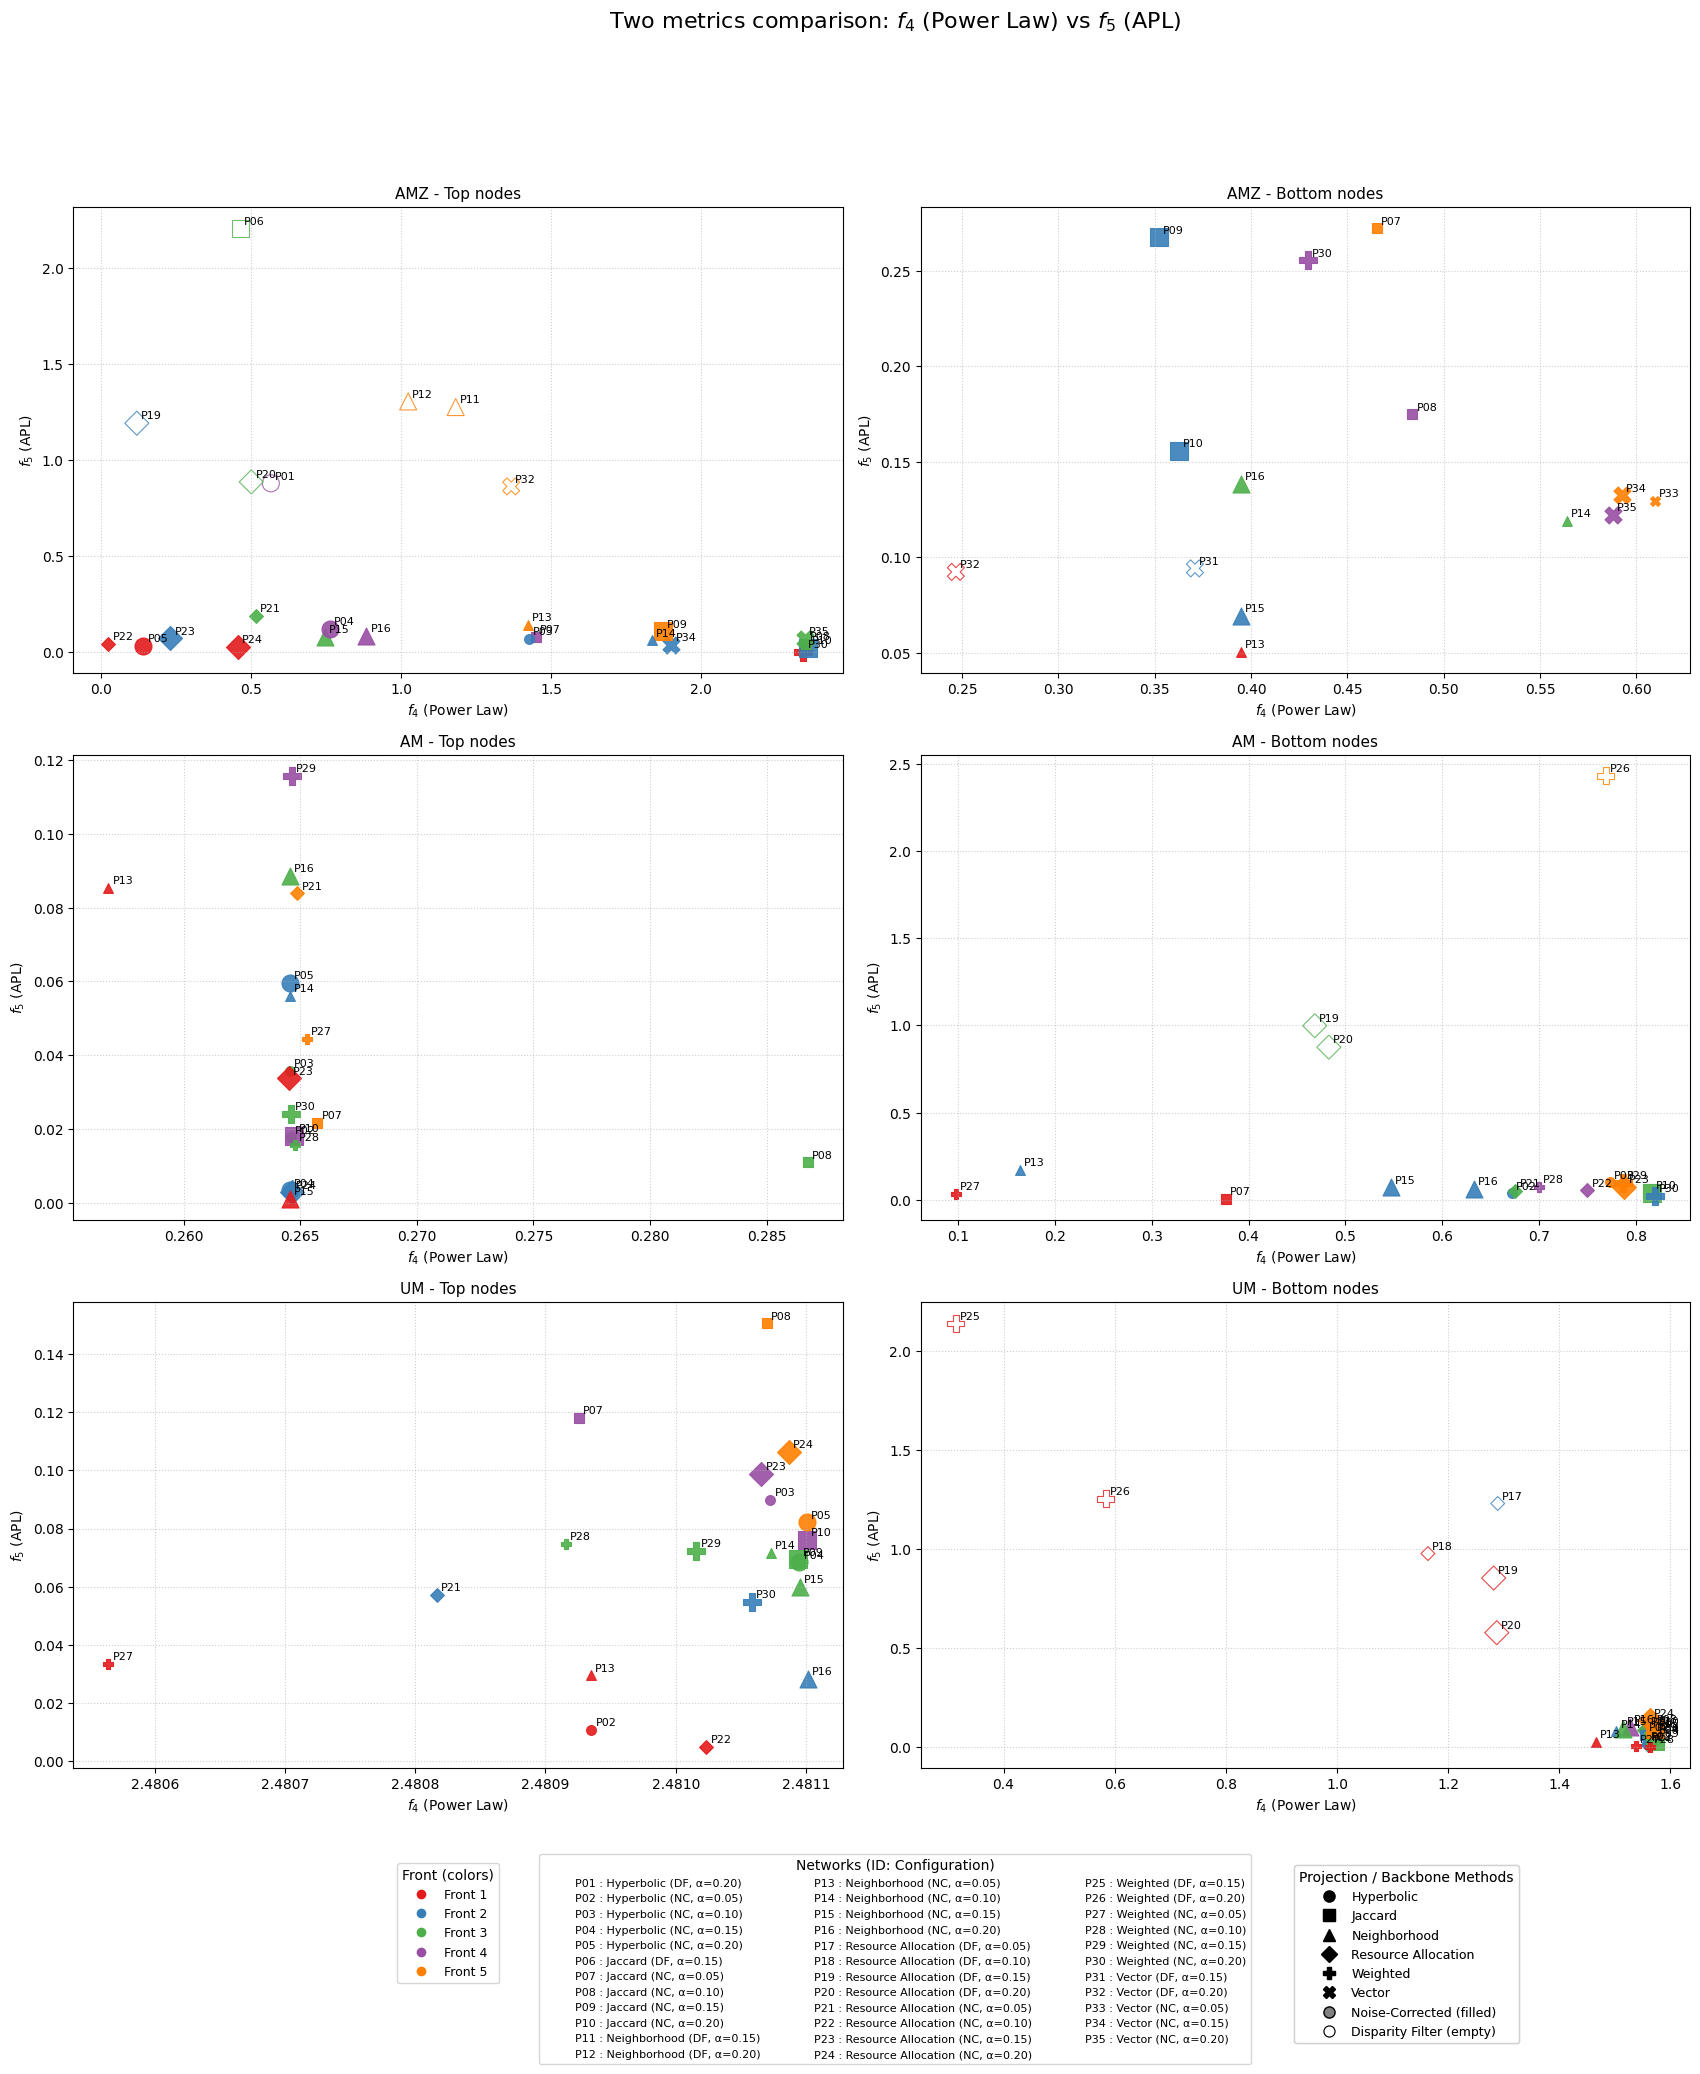

In [26]:
import os
import pickle
import igraph as ig
import numpy as np
import pandas as pd
import statistics
import matplotlib.cm as cm # <--- ESTO ARREGLA NameError: name 'cm' is not defined
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# --------------------------------------------------------
# CONFIGURACIÓN GENERAL
# --------------------------------------------------------
DATASETS = ["amz", "am", "um"]
NODETYPES = [0, 1]  # 0 = top, 1 = bottom
METRIC_PAIR = (3, 4)  # FO4 vs FO5
FO_NAMES = ['$f_1$ (Nodos)', '$f_2$ (Densidad)', '$f_3$ (CC)',
            '$f_4$ (Power Law)', '$f_5$ (APL)', '$f_6$ (Grado Promedio)']

proj_names_map = {
    'hyper': 'Hyperbolic',
    'jaccard': 'Jaccard',
    'neighs': 'Neighborhood',
    'resall': 'Resource Allocation',
    'simple': 'Weighted'
}
alpha_names_map = {
    'a05': 'α=0.05',
    'a1': 'α=0.10',
    'a15': 'α=0.15',
    'a2': 'α=0.20'
}

def decode_solution_name(sol_key):
    """Convierte hyper_nc_a05 -> Hyperbolic (NC, α=0.05)"""
    parts = sol_key.split('_')
    if len(parts) == 3:
        proj, bb, alpha = parts
        proj = proj_names_map.get(proj, proj.capitalize())
        alpha = alpha_names_map.get(alpha, alpha)
        return f"{proj} ({bb.upper()}, {alpha})"
    return sol_key

# --------------------------------------------------------
# FUNCIONES AUXILIARES (idénticas a las tuyas)
# --------------------------------------------------------
def evaluate_solution(bip, proj, typen, metric_pair):
    all_f_values = [
        abs(bip["x1"] - proj["x4"]) if typen == 0 else abs(bip["x2"] - proj["x4"]),
        abs(((2 * proj["x5"]) / (proj["x4"] * (proj["x4"] - 1))) - bip["x15"]),
        abs(bip["x8"] - proj["x7"]),
        abs(bip["x11"] - proj["x12"]),
        abs(bip["x9"] - proj["x10"]),
        abs(proj["x13"] - bip["x16"])
    ]
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]]
    ])
    g = np.array([
        (bip["x1"] / 2) - proj["x4"] if typen == 0 else (bip["x2"] / 2) - proj["x4"],
        (bip["x1"] - 1) - proj["x5"] if typen == 0 else (bip["x2"] - 1) - proj["x5"]
    ])
    return dict(metrics={**bip, **proj}, f=f, g=g, graph=proj)

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_rank_all(solutions):
    remaining = solutions.copy()
    fronts = []
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    return fronts

# --------------------------------------------------------
# MÉTRICAS BIPARTITAS (tus valores estáticos)
# --------------------------------------------------------
BIP_METRICS = {
    "amz": {
        0: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.7071, 'x11': 3.8553},
        1: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.9545, 'x11': 2.1547}
    },
    "am": {
        0: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.6699, 'x11': 1.8623},
        1: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.2322, 'x11': 5.0662}
    },
    "um": {
        0: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.6599, 'x11': 4.4055},
        1: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.1522, 'x11': 4.2186}
    }
}

# --------------------------------------------------------
# UTIL: extraer proyección/backbone/alpha desde base_name robustamente
# base_name viene de: fname.replace("_metrics.pkl","")
# esperamos nombres tipo:
#   amz_top_hyper_NC_a05_metrics.pkl  -> base_name: amz_top_hyper_NC_a05
#   o bien: hyper_NC_a05_metrics.pkl  -> base_name: hyper_NC_a05
# Tomamos los últimos 3 campos como projection, backbone, alpha
# --------------------------------------------------------
def parse_solution_name(base_name):
    parts = base_name.split('_')
    if len(parts) >= 3:
        proj = parts[-3].lower()
        bb = parts[-2].upper()   # 'NC' o 'DF' (forzamos mayúsculas)
        alpha = parts[-1].lower()  # 'a05' ...
    else:
        # fallback defensivo
        proj = parts[0].lower()
        bb = parts[1].upper() if len(parts) > 1 else 'NC'
        alpha = parts[2].lower() if len(parts) > 2 else 'a05'
    # normalizar nombres comunes
    proj = proj.replace('hyperbolic', 'hyper')  # por si acaso
    return proj, bb, alpha

# --------------------------------------------------------
# get_solutions: carga métricas proyectadas y construye plot_DF
# --------------------------------------------------------
def get_solutions(dataset, nodetype, metric_pair):
    print(f"\n>>> Procesando {dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES")

    # Rutas a archivos (ajusta si tus paths son distintas)
    if dataset == "um":
        FILENAME = "um/user-movie.graphml"
    elif dataset == "am":
        FILENAME = "am/actor-movie.graphml"
    elif dataset == "amz":
        FILENAME = "binet-AMZ-Rw.graphml"

    # Leer grafo para calcular x15 y x16
    gb = ig.Graph.Read_GraphML(FILENAME)

    # bip metrics base + x15, x16 calculadas
    bip_metrics = BIP_METRICS[dataset][nodetype].copy()
    bip_metrics['x15'] = gb.density()
    bip_metrics['x16'] = statistics.mean(gb.degree(gb.vs.select(type=nodetype)))

    proj_dir = dataset + ("/top" if nodetype == 0 else "/bot")
    metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
    if not os.path.isdir(metrics_cache_dir):
        print(f"Warning: no existe el directorio {metrics_cache_dir}. Se omite.")
        return pd.DataFrame(), []

    metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
    if not metrics_files:
        print(f"Warning: no hay archivos *_metrics.pkl en {metrics_cache_dir}.")
        return pd.DataFrame(), []

    records = []
    solutions = []

    for fname in metrics_files:
        base_name = fname.replace("_metrics.pkl", "")
        with open(os.path.join(metrics_cache_dir, fname), 'rb') as fh:
            proj_metrics = pickle.load(fh)

        sol = evaluate_solution(bip_metrics, proj_metrics, nodetype, metric_pair)
        # parsear solución sin prefijo dataset/nodetype:
        proj_name, bb_name, alpha_val = parse_solution_name(base_name)
        solution_key = f"{proj_name}_{bb_name.lower()}_{alpha_val}"  # ej. hyper_nc_a05

        sol["filename"] = base_name  # archivo original (puede contener dataset prefijo)
        sol["solution_key"] = solution_key  # el identificador que queremos usar (sin dataset)
        if is_feasible(sol):
            solutions.append(sol)
            f1, f2 = sol["f"].tolist()
            records.append({
                "Solucion": solution_key,
                "Proyeccion": proj_name,
                "Backbone": bb_name,
                "Alpha": alpha_val,
                "f1": f1,
                "f2": f2,
                "OriginalFile": base_name
            })

    if not solutions:
        return pd.DataFrame(), []

    all_fronts = pareto_rank_all(solutions)

    # Solo conservamos las soluciones que están en los primeros 5 frentes
    top5_names = [s["solution_key"] for rank, front in enumerate(all_fronts, start=1) if rank <= 5 for s in front]
    plot_DF = pd.DataFrame(records)
    plot_DF = plot_DF[plot_DF["Solucion"].isin(top5_names)].reset_index(drop=True)

    # Agregar columna "Frente" usando el mapping por filename (buscamos filename->rank)
    frente_map = {}
    for rank, front in enumerate(all_fronts, start=1):
        for s in front:
            # s["solution_key"] es la clave que usamos
            frente_map[s["solution_key"]] = rank
    plot_DF["Frente"] = plot_DF["Solucion"].map(frente_map).fillna(999).astype(int)

    # Añadir metadatos de dataset y tipo para filtrar luego
    plot_DF["Dataset"] = dataset.upper()
    plot_DF["Tipo"] = "TOP" if nodetype == 0 else "BOTTOM"

    return plot_DF, all_fronts

# --------------------------------------------------------
# RECOLECTAR TODOS LOS DATOS PARA LAS 6 SUBGRÁFICAS
# --------------------------------------------------------
all_plots = []
all_fronts_global = {}  # opcional: almacenar frentes por dataset/nodetype

for dataset in DATASETS:
    for nodetype in NODETYPES:
        df, fronts = get_solutions(dataset, nodetype, METRIC_PAIR)
        if not df.empty:
            all_plots.append(df)
        all_fronts_global[(dataset, nodetype)] = fronts

if not all_plots:
    raise SystemExit("No se encontraron soluciones factibles en ninguno de los datasets/directorios.")

plot_DF = pd.concat(all_plots, ignore_index=True)

# --------------------------------------------------------
# CONFIGURACIÓN DE MARCADORES, RELLENO Y TAMAÑOS (según tus reglas)
# --------------------------------------------------------
# Markers por proyección (asegura cubrir tus 6 nombres)
unique_projections = sorted(plot_DF['Proyeccion'].unique())
marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*']
PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

# Backbone: NC -> lleno (True), DF -> no lleno (False)
BB_FILLED_STATUS = {'NC': True, 'DF': False}
# Si hay otros valores, asumimos DF por defecto
plot_DF['is_filled'] = plot_DF['Backbone'].map(lambda x: BB_FILLED_STATUS.get(x, False))

# Alpha -> tamaños
def alpha_size(alpha_str):
    a = alpha_str.lower()
    if a in ('a05', 'a1'):      # pequeño
        return 50
    if a in ('a15', 'a2'):      # grande
        return 150
    # por defecto tamaño medio
    return 100

plot_DF['size'] = plot_DF['Alpha'].map(alpha_size)

# --------------------------------------------------------
# Colores por frente: usaremos frentes 1..5 (si faltan algunos, no importa)
# --------------------------------------------------------
max_front = 5
# OPCIÓN 1: Paleta tab10 (muy clara y contrastante, recomendada)
palette = ListedColormap([
    "#E41A1C",  # rojo fuerte
    "#377EB8",  # azul intenso
    "#4DAF4A",  # verde
    "#984EA3",  # violeta
    "#FF7F00"   # naranja
])

# Asigna color a cada frente de Pareto
FRONT_COLORS = {r: palette(r - 1) for r in range(1, max_front + 1)}

# --------------------------------------------------------
# Generar IDs consistentes S01, S02, ... basados en soluciones únicas
# (ordenadas alfabéticamente para consistencia)
# --------------------------------------------------------
unique_sols = sorted(plot_DF['Solucion'].unique())
shared_ids = {sol: f"P{idx+1:02d}" for idx, sol in enumerate(unique_sols)}

# --------------------------------------------------------
# CREAR FIGURA 3x2 (AMZ, AM, UM filas × TOP,BOTTOM columnas)
# --------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle("Two metrics comparison: $f_4$ (Power Law) vs $f_5$ (APL)\n", fontsize=16)


f_name1, f_name2 = FO_NAMES[3], FO_NAMES[4]

for i, dataset in enumerate(DATASETS):
    for j, nodetype in enumerate(NODETYPES):
        ax = axes[i, j]
        sub_df = plot_DF[(plot_DF["Dataset"] == dataset.upper()) &
                         (plot_DF["Tipo"] == ("TOP" if nodetype == 0 else "BOTTOM"))]

        ax.set_title(f"{dataset.upper()} - {'Top' if nodetype==0 else 'Bottom'} nodes", fontsize=11)
        ax.set_xlabel(f_name1)
        ax.set_ylabel(f_name2)
        ax.grid(True, linestyle=":", alpha=0.6)

        # si no hay datos, indicarlo
        if sub_df.empty:
            ax.text(0.5, 0.5, "No hay soluciones\n(ó no hay archivos)", ha='center', va='center', fontsize=10)
            continue

        # Graficar cada punto según reglas
        for _, row in sub_df.iterrows():
            rank = int(row["Frente"])
            if rank < 1 or rank > 5:
                continue  # mostramos solo frentes 1..5

            color = FRONT_COLORS.get(rank, (0.6, 0.6, 0.6))
            marker = PROJ_MARKERS.get(row["Proyeccion"], 'o')
            face = color if row['is_filled'] else 'none'
            edge = color

            ax.scatter(
                row["f1"], row["f2"],
                s=row["size"],
                marker=marker,
                facecolors=face,
                edgecolors=edge,
                linewidth=0.8,
                alpha=0.9 if row['is_filled'] else 0.8
            )

            # Anotar con ID compartida
            ax.annotate(shared_ids[row["Solucion"]],
                        (row["f1"], row["f2"]),
                        fontsize=8, textcoords="offset points", xytext=(3, 3))

# --------------------------------------------------------
# LEYENDA GLOBAL: Frentes (colores)
# --------------------------------------------------------
front_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=FRONT_COLORS[f], label=f'Front {f}',
               markersize=8)
    for f in sorted(FRONT_COLORS.keys())
]

fig.legend(handles=front_handles,
           title="Front (colors)",
           loc='lower left',       # posición
           ncol=1,                 # una sola columna → vertical
           fontsize=9,  bbox_to_anchor=(0.22, -0.01))


# --------------------------------------------------------
# LEYENDA GLOBAL: Proyecciones (marcadores) y Backbone (filled vs empty)
# Creamos handles por proyección y por tipo backbone
# --------------------------------------------------------
proj_handles = []
for proj, m in PROJ_MARKERS.items():
    # Usa el nombre completo del diccionario proj_names_map
    label_full = proj_names_map.get(proj, proj.capitalize())
    h = plt.Line2D([], [], marker=m, color='black', linestyle='',
                   markerfacecolor='black', markersize=8, label=label_full)
    proj_handles.append(h)

# Backbone (relleno vs vacío)
bb_filled = plt.Line2D([], [], marker='o', color='black', linestyle='',
                       markerfacecolor='gray', markersize=8, label='Noise-Corrected (filled)')
bb_empty = plt.Line2D([], [], marker='o', color='black', linestyle='',
                      markerfacecolor='none', markeredgewidth=0.8, markersize=8, label='Disparity Filter (empty)')

# Leyenda combinada (proyecciones y backbone)
leg1 = fig.legend(handles=proj_handles + [bb_filled, bb_empty],
                  title="Projection / Backbone Methods",
                  loc='lower right', fontsize=9,
                  bbox_to_anchor=(0.85, -0.04))

# --------------------------------------------------------
# LEYENDA GLOBAL: Soluciones (Sxx : nombre)
# --------------------------------------------------------
solution_labels = [f"{shared_ids[sol]} : {decode_solution_name(sol)}" for sol in unique_sols]

ncols = 3  # número de columnas en la leyenda
solution_proxies = [plt.Line2D([], [], linestyle='none') for _ in solution_labels]

leg2 = fig.legend(solution_proxies, solution_labels, title="Networks (ID: Configuration)", bbox_to_anchor=(0.5, -0.05),
                  loc='lower center', ncol=ncols, fontsize=8)

# Añadir la leyenda de proyecciones/backbones al axes para que no se remueva
fig.gca().add_artist(leg1)

plt.tight_layout(rect=[0, 0.07, 0.95, 0.93])
plt.show()



/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_37013/1895068708.py:104: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_37013/1895068708.py:104: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)


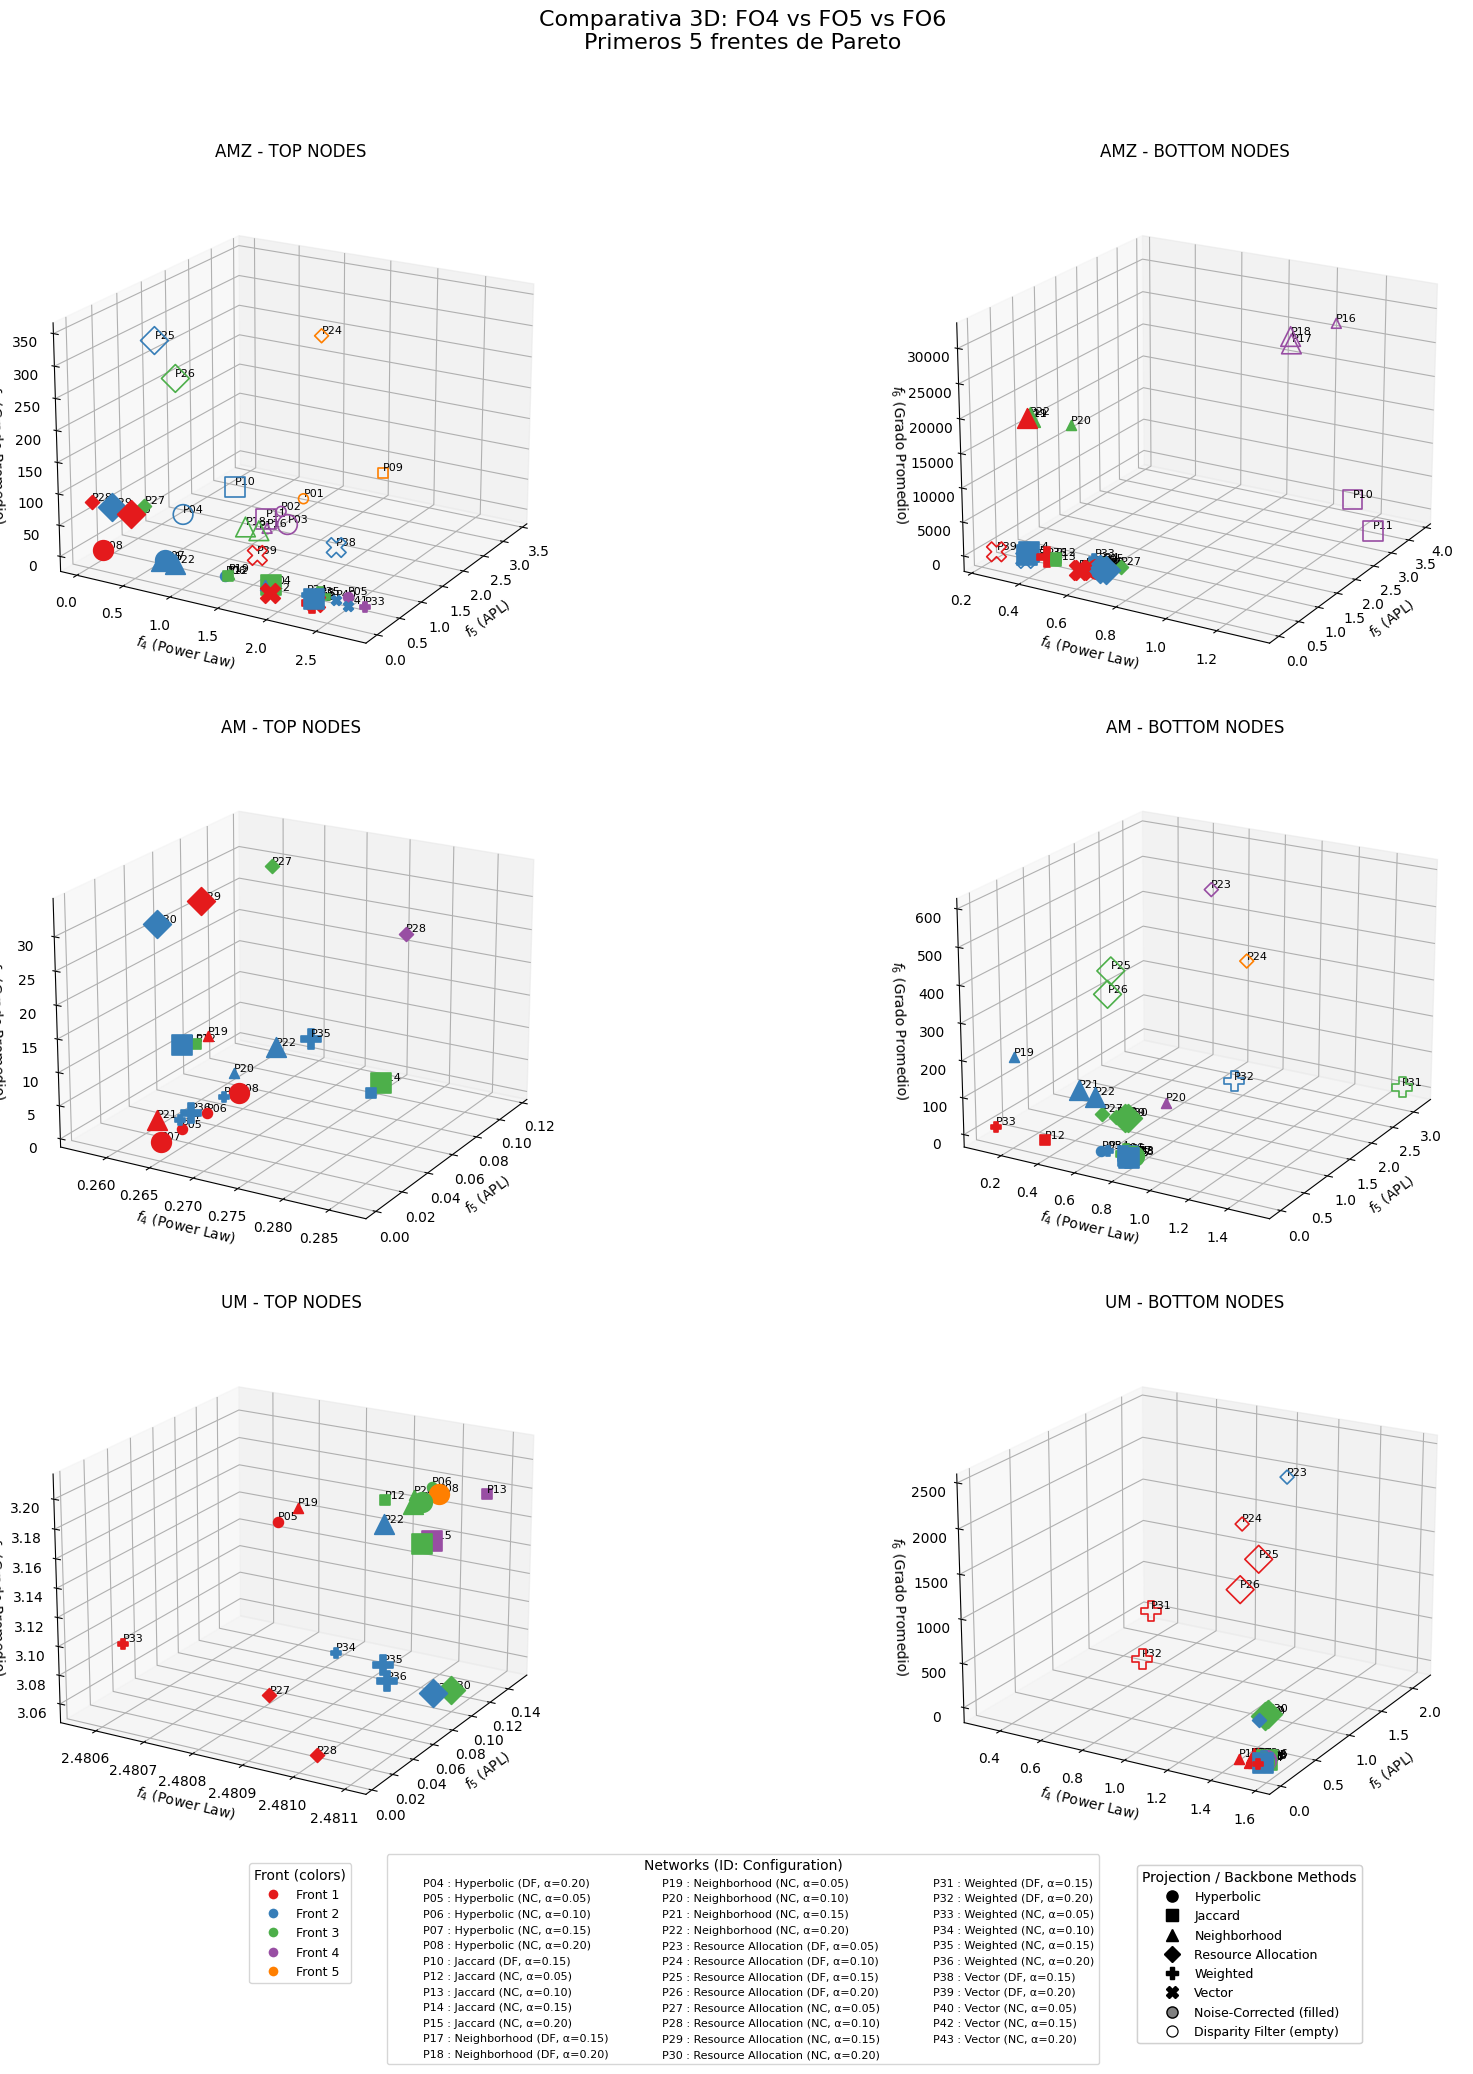

In [25]:
import os
import pickle
import igraph as ig
import numpy as np
import pandas as pd
import statistics
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# CONFIGURACIÓN GENERAL
# --------------------------------------------------------
DATASETS = ["amz", "am", "um"]
NODETYPES = [0, 1]  # 0 = top, 1 = bottom
METRIC_TRIPLE = (3, 4, 5)  # FO4, FO5, FO6
FO_NAMES = ['$f_1$ (Nodos)', '$f_2$ (Densidad)', '$f_3$ (CC)',
            '$f_4$ (Power Law)', '$f_5$ (APL)', '$f_6$ (Grado Promedio)']

# --------------------------------------------------------
# FUNCIONES AUXILIARES
# --------------------------------------------------------
def evaluate_solution(bip, proj, typen, metric_triple):
    all_f_values = [
        abs(bip["x1"] - proj["x4"]) if typen == 0 else abs(bip["x2"] - proj["x4"]),
        abs(((2 * proj["x5"]) / (proj["x4"] * (proj["x4"] - 1))) - bip["x15"]),
        abs(bip["x8"] - proj["x7"]),
        abs(bip["x11"] - proj["x12"]),
        abs(bip["x9"] - proj["x10"]),
        abs(proj["x13"] - bip["x16"])
    ]
    f = np.array([
        all_f_values[metric_triple[0]],
        all_f_values[metric_triple[1]],
        all_f_values[metric_triple[2]]
    ])
    g = np.array([
        (bip["x1"]/2) - proj["x4"] if typen == 0 else (bip["x2"]/2) - proj["x4"],
        (bip["x1"]-1) - proj["x5"] if typen == 0 else (bip["x2"]-1) - proj["x5"]
    ])
    return dict(metrics={**bip, **proj}, f=f, g=g, graph=proj)

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_rank_all(solutions):
    remaining = solutions.copy()
    fronts = []
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    return fronts

# --------------------------------------------------------
# MÉTRICAS BIPARTITAS (valores fijos)
# --------------------------------------------------------
BIP_METRICS = {
    "amz": {
        0: {'x1':9561,'x2':7518,'x3':32769,'x8':0.2629,'x9':2.7071,'x11':3.8553},
        1: {'x1':9561,'x2':7518,'x3':32769,'x8':0.2629,'x9':2.9545,'x11':2.1547}
    },
    "am": {
        0: {'x1':511463,'x2':127823,'x3':511463,'x8':0.3253,'x9':3.6699,'x11':1.8623},
        1: {'x1':511463,'x2':127823,'x3':511463,'x8':0.3253,'x9':3.2322,'x11':5.0662}
    },
    "um": {
        0: {'x1':896302,'x2':303617,'x3':1199919,'x8':0.2571,'x9':3.6599,'x11':4.4055},
        1: {'x1':896302,'x2':303617,'x3':1199919,'x8':0.2571,'x9':3.1522,'x11':4.2186}
    }
}

def parse_solution_name(base_name):
    parts = base_name.split('_')
    if len(parts) >= 3:
        proj = parts[-3].lower()
        bb = parts[-2].upper()
        alpha = parts[-1].lower()
    else:
        proj, bb, alpha = parts[0], 'NC', 'a05'
    proj = proj.replace('hyperbolic', 'hyper')
    return proj, bb, alpha

# --------------------------------------------------------
# get_solutions
# --------------------------------------------------------
def get_solutions(dataset, nodetype, metric_triple):
    FILENAME = {
        "amz": "binet-AMZ-Rw.graphml",
        "am": "am/actor-movie.graphml",
        "um": "um/user-movie.graphml"
    }[dataset]
    gb = ig.Graph.Read_GraphML(FILENAME)
    bip_metrics = BIP_METRICS[dataset][nodetype].copy()
    bip_metrics["x15"] = gb.density()
    bip_metrics["x16"] = statistics.mean(gb.degree(gb.vs.select(type=nodetype)))

    proj_dir = dataset + ("/top" if nodetype == 0 else "/bot")
    metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
    if not os.path.isdir(metrics_cache_dir):
        return pd.DataFrame(), []

    metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
    records, solutions = [], []

    for fname in metrics_files:
        base_name = fname.replace("_metrics.pkl", "")
        with open(os.path.join(metrics_cache_dir, fname), "rb") as fh:
            proj_metrics = pickle.load(fh)
        sol = evaluate_solution(bip_metrics, proj_metrics, nodetype, metric_triple)
        proj_name, bb_name, alpha_val = parse_solution_name(base_name)
        solution_key = f"{proj_name}_{bb_name.lower()}_{alpha_val}"
        sol["filename"] = base_name
        sol["solution_key"] = solution_key
        if is_feasible(sol):
            solutions.append(sol)
            f1, f2, f3 = sol["f"].tolist()
            records.append({
                "Solucion": solution_key,
                "Proyeccion": proj_name,
                "Backbone": bb_name,
                "Alpha": alpha_val,
                "f1": f1, "f2": f2, "f3": f3
            })

    if not solutions:
        return pd.DataFrame(), []
    all_fronts = pareto_rank_all(solutions)
    top5_names = [s["solution_key"] for r, f in enumerate(all_fronts, 1) if r <= 5 for s in f]
    df = pd.DataFrame(records)
    df = df[df["Solucion"].isin(top5_names)].reset_index(drop=True)
    frente_map = {s["solution_key"]: r for r, f in enumerate(all_fronts, 1) for s in f}
    df["Frente"] = df["Solucion"].map(frente_map)
    df["Dataset"] = dataset.upper()
    df["Tipo"] = "TOP" if nodetype == 0 else "BOTTOM"
    return df, all_fronts

# --------------------------------------------------------
# RECOLECTAR TODOS LOS DATOS
# --------------------------------------------------------
all_plots = []
for d in DATASETS:
    for n in NODETYPES:
        df, _ = get_solutions(d, n, METRIC_TRIPLE)
        if not df.empty:
            all_plots.append(df)
plot_DF = pd.concat(all_plots, ignore_index=True)

# --------------------------------------------------------
# CONFIG VISUAL
# --------------------------------------------------------
unique_proj = sorted(plot_DF["Proyeccion"].unique())
PROJ_MARKERS = dict(zip(unique_proj, ['o', 's', '^', 'D', 'P', 'X', 'v']))
BB_FILLED_STATUS = {'NC': True, 'DF': False}
plot_DF['is_filled'] = plot_DF['Backbone'].map(lambda x: BB_FILLED_STATUS.get(x, False))
plot_DF["size"] = plot_DF["Alpha"].map(lambda a: 50 if a in ("a05", "a1") else 200)

palette = ListedColormap(["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00"])
FRONT_COLORS = {r: palette(r-1) for r in range(1,6)}
shared_ids = {s:f"P{idx+1:02d}" for idx,s in enumerate(sorted(plot_DF["Solucion"].unique()))}

# --------------------------------------------------------
# FIGURA 3D
# --------------------------------------------------------
fig = plt.figure(figsize=(25, 20))
fig.suptitle("Comparativa 3D: FO4 vs FO5 vs FO6\nPrimeros 5 frentes de Pareto", fontsize=16)
axes = []
for i in range(6):
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    axes.append(ax)

for i, d in enumerate(DATASETS):
    for j, n in enumerate(NODETYPES):
        idx = i*2 + j
        ax = axes[idx]
        sub = plot_DF[(plot_DF["Dataset"]==d.upper()) & (plot_DF["Tipo"]==("TOP" if n==0 else "BOTTOM"))]
        ax.set_title(f"{d.upper()} - {'TOP' if n==0 else 'BOTTOM'} NODES")
        ax.set_xlabel(FO_NAMES[3])
        ax.set_ylabel(FO_NAMES[4])
        ax.set_zlabel(FO_NAMES[5])
        if sub.empty: continue
        for _,r in sub.iterrows():
            if r["Frente"]>5: continue
            color = FRONT_COLORS[r["Frente"]]
            marker = PROJ_MARKERS.get(r["Proyeccion"],'o')
            face = color if r["is_filled"] else 'none'
            edge = color
            ax.scatter(r["f1"],r["f2"],r["f3"],s=r["size"],marker=marker,
                       facecolors=face,edgecolors=edge,linewidths=1.2)
            ax.text(r["f1"],r["f2"],r["f3"],shared_ids[r["Solucion"]],
                    fontsize=8,ha='left',va='bottom')
            ax.view_init(elev=20, azim=-60)
            ax.zaxis._axinfo['juggled'] = (1, 2, 0)


# --------------------------------------------------------
# LEYENDA GLOBAL: Frentes (colores)
# --------------------------------------------------------
front_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=FRONT_COLORS[f], label=f'Front {f}',
               markersize=8)
    for f in sorted(FRONT_COLORS.keys())
]

fig.legend(handles=front_handles,
           title="Front (colors)",
           loc='lower left',       # posición
           ncol=1,                 # una sola columna → vertical
           fontsize=9,  bbox_to_anchor=(0.30, -0.01))


# --------------------------------------------------------
# LEYENDA GLOBAL: Proyecciones (marcadores) y Backbone (filled vs empty)
# Creamos handles por proyección y por tipo backbone
# --------------------------------------------------------
proj_handles = []
for proj, m in PROJ_MARKERS.items():
    # Usa el nombre completo del diccionario proj_names_map
    label_full = proj_names_map.get(proj, proj.capitalize())
    h = plt.Line2D([], [], marker=m, color='black', linestyle='',
                   markerfacecolor='black', markersize=8, label=label_full)
    proj_handles.append(h)

# Backbone (relleno vs vacío)
bb_filled = plt.Line2D([], [], marker='o', color='black', linestyle='',
                       markerfacecolor='gray', markersize=8, label='Noise-Corrected (filled)')
bb_empty = plt.Line2D([], [], marker='o', color='black', linestyle='',
                      markerfacecolor='none', markeredgewidth=0.8, markersize=8, label='Disparity Filter (empty)')

# Leyenda combinada (proyecciones y backbone)
leg1 = fig.legend(handles=proj_handles + [bb_filled, bb_empty],
                  title="Projection / Backbone Methods",
                  loc='lower right', fontsize=9,
                  bbox_to_anchor=(0.75, -0.04))

# --------------------------------------------------------
# LEYENDA GLOBAL: Soluciones (Sxx : nombre)
# --------------------------------------------------------
solution_labels = [f"{shared_ids[sol]} : {decode_solution_name(sol)}" for sol in unique_sols]

ncols = 3  # número de columnas en la leyenda
solution_proxies = [plt.Line2D([], [], linestyle='none') for _ in solution_labels]

leg2 = fig.legend(solution_proxies, solution_labels, title="Networks (ID: Configuration)", bbox_to_anchor=(0.5, -0.05),
                  loc='lower center', ncol=ncols, fontsize=8)

# Añadir la leyenda de proyecciones/backbones al axes para que no se remueva
fig.gca().add_artist(leg1)


#  Forzar a que matplotlib vuelva a calcular los lími
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()
